# Lab 7: Dynamic Programming

University of California Berkeley

ME C231A, EE C220B, Experiential Advanced Control I

***

These notes were developed by Roya Firoozi and Francesco Borrelli at UC Berkeley. They are protected by U.S. copyright law and by University policy (https://copyright.universityofcalifornia.edu/resources/ownership-course-materials.html).

If you are enrolled in ME C231A/EE C220B you may take notes and make copies of course materials for your own use. You may also share those materials with another student who is registered and enrolled in this course, and with DSP.

You may not reproduce, distribute or display (post/upload) (Links to an external site.) lecture notes or recordings or course materials in any other way — whether or not a fee is charged — without my express written consent. You also may not allow others to do so. If you do so, you may be subject to student conduct proceedings under the Links to an external site.Berkeley Code of Student Conduct, including Sections 102.23 and 102.25.

***

# <font color=blue> Linear CFTOC via Dynamic Programming </font>

Consider CFTOC of a discrete-time double-integrator system:
\begin{align}
\min_{\substack{ u_0,\dots,u_{N-1} \\ x_1,\dots,x_N }} ~&~ x_N^TPx_N + \displaystyle{\sum}_{k=0}^{N-1}  x_k^TQx_k + u_k^TRu_k \\
\text{subject to} ~&~ x_{k+1}=
\begin{bmatrix} 1 & 1 \\  0 & 1 \end{bmatrix}
x_k
+
\begin{bmatrix} 0 \\ 1 \end{bmatrix}
u_k \\
& -1 \leq u_k \leq 1, ~k \in \left\{ 0, \ldots, N-1 \right\} \\
& \begin{bmatrix} -15 \\ -15 \end{bmatrix} \leq x(k) \leq \begin{bmatrix} 15 \\ 15 \end{bmatrix}, ~k \in \left\{ 1, \ldots, N \right\}
\end{align}
where $N = 3$, $P = Q = \mathcal{I}_{2 \times 2}$, $R = 0.1$.

Compute the state feedback solution using the DP algorithm. The optimal state trajectory is a $2 \times (N+1)$ matrix, and the optimal control sequence is a vector of $1 \times N$. If the initial condition is infeasible, then the optimal state trajectory and the optimal input trajectories should be empty arrays. The initial condition $\texttt{x0}$, the horizon length $\texttt{N}$, the number of grid points in each state dimension $\texttt{nXgrid}$, and the number of grid points in each input dimension $\texttt{nUgrid}$ are given.

For the initial point $x_0 = [-1, -1]^T$, compare the input sequence obtained from the DP solution with the one obtained with the batch solution in homework 4. Use the following parameters for your DP implementation: $\texttt{N}=3$, $\texttt{nXgrid}=100$, $\texttt{nUgrid}=21$.
*Note:* our implementation takes approximately 1 minute to run with these parameters, run time will vary based on computer hardware differences).

In [ ]:
import numpy as np
import scipy as sp
import scipy.interpolate
import multiprocessing

pool = multiprocessing.Pool(4)

# Define system
A = np.array([[1, 1],
              [0, 1]])
B = np.array([[0],
              [1]])
nX = 2
nU = 1

fDyn = lambda x, u : A @ np.array([x]).reshape(nX,1) + B @ np.array([u]).reshape(nU,1)

# State constraints (Box)
xmin = -15.0
xmax = 15.0

# Input constraints (Box)
umin =-1.0
umax = 1.0

# Horizon
N = 3

# Cost matrices
Q = np.eye(2)
R = np.array([0.1]).reshape(nU,nU)
PN = np.eye(2)

# Create anonymous functions for Stage Cost and "optimal Cost-to-Go".
# Since the optimal cost-to-go is a function (of the state) and changes
# with time, store this as function , as dictionary.

Jstage = lambda x, u : np.array([x]).reshape(nX,1).T @ Q @ np.array([x]).reshape(nX,1) + np.array([u]).reshape(nU,1).T @ R @ np.array([u]).reshape(nU,1)

Jopt = {}
Uopt = {}

## Grid the set X (satisfies state constraints), in state-space
nXgrid = 50
X1 = np.linspace(xmin, xmax, nXgrid)
X2 = np.linspace(xmin, xmax, nXgrid)
points = (X1, X2)

## Grid Input space
nUgrid = 21
Ugrid = np.linspace(umin, umax, nUgrid)


# Allocate memory for Jopt and Uopt arrays
# Jopt[N] is a known, quadratic function (from PN).
JoptArray = np.nan*np.zeros((nXgrid, nXgrid, N+1))
UoptArray = np.nan*np.zeros((nXgrid, nXgrid, N))

# Constructing base cases, i.e., terminal costs
for idx1, x1 in enumerate(X1):
    for idx2, x2 in enumerate(X2):
        x = np.array([x1, x2]).reshape(nX, )
        JoptArray[idx1, idx2, N] = x.reshape(nX,1).T @ PN @ x.reshape(nX,1)

# Interpolator
Jopt = lambda x, j: scipy.interpolate.interpn(points, JoptArray[:, :, j], x.flatten(), method='linear')
Uopt = lambda x, j: scipy.interpolate.interpn(points, UoptArray[:, :, j], x.flatten(), method='linear')

for k in reversed(range(N)):
    print('===== Computing step:', k, '=====')
    # Loop over the 2-dimensional grid in X
    for idx1, x1 in enumerate(X1):
        for idx2, x2 in enumerate(X2):
            xi = np.array([x1, x2]).reshape(nX,)
            Jtimek_givenxi = lambda u: Jstage(xi, u).flatten() + Jopt(fDyn(xi, u), k+1).flatten()
            JBest = np.inf
            UBest = np.NaN
            # Find "minimum" over u by brute-force gridding of input space
            for uVal in Ugrid:
                xiNext = fDyn(xi, uVal)
                # Check if input choice leads to an x in X (the state constraint box)
                if np.all(xiNext>=xmin) and np.all(xiNext<=xmax):
                    Jact = Jtimek_givenxi(uVal)
                    if Jact<JBest:
                        # Record current best cost and best input
                        UBest = uVal
                        JBest = Jact
                        # Store optimal input and optimal cost at this xi-value
                        JoptArray[idx1, idx2, k] = JBest
                        UoptArray[idx1, idx2, k] = UBest


x = np.array([-1, -1])
print(Jopt(x,0))

[-15.         -14.3877551  -13.7755102  -13.16326531 -12.55102041
 -11.93877551 -11.32653061 -10.71428571 -10.10204082  -9.48979592
  -8.87755102  -8.26530612  -7.65306122  -7.04081633  -6.42857143
  -5.81632653  -5.20408163  -4.59183673  -3.97959184  -3.36734694
  -2.75510204  -2.14285714  -1.53061224  -0.91836735  -0.30612245
   0.30612245   0.91836735   1.53061224   2.14285714   2.75510204
   3.36734694   3.97959184   4.59183673   5.20408163   5.81632653
   6.42857143   7.04081633   7.65306122   8.26530612   8.87755102
   9.48979592  10.10204082  10.71428571  11.32653061  11.93877551
  12.55102041  13.16326531  13.7755102   14.3877551   15.        ]
===== Computing step: 2 =====
===== Computing step: 1 =====
===== Computing step: 0 =====
[14.18178829]


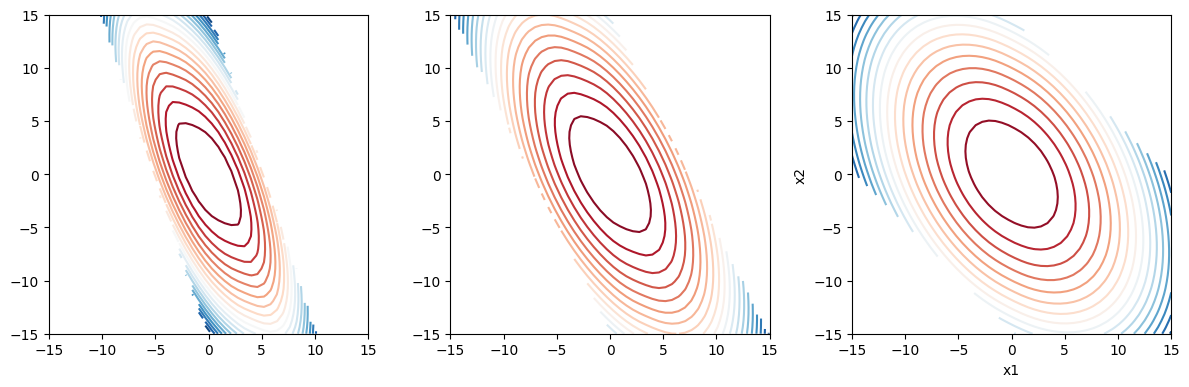

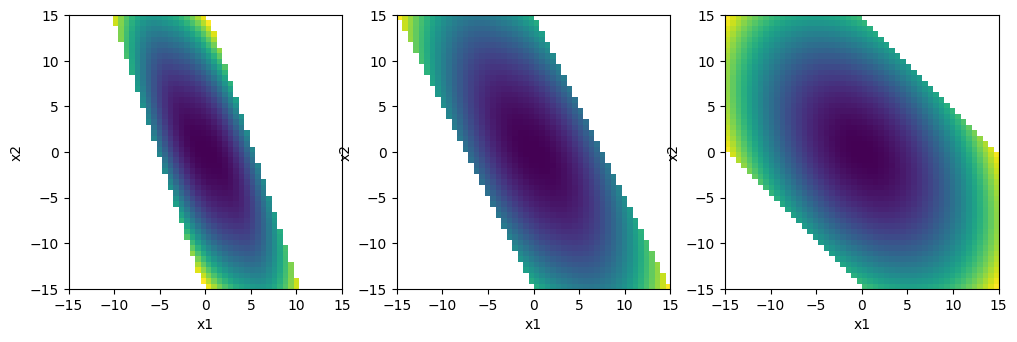

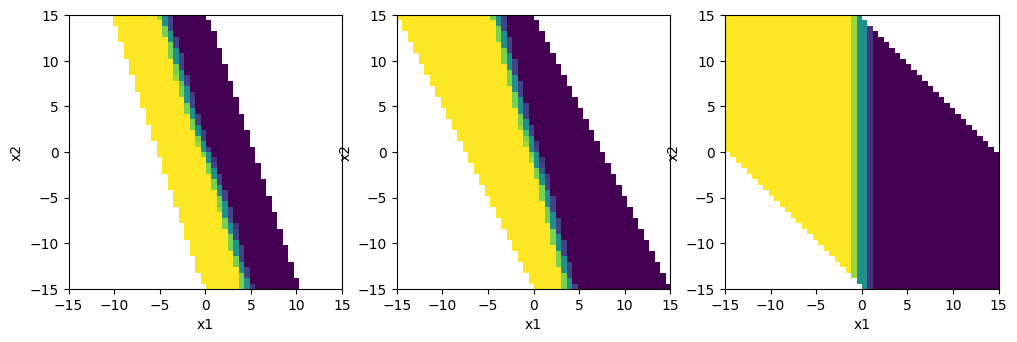

In [ ]:
## Simulate from any chosen initial condition.
from mpl_toolkits.mplot3d.axes3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm

fig, ax = plt.subplots(1, N, figsize=(12, 6))
for j in range(N):
    ax[j].contour(JoptArray[:,:,j], 20, cmap=cm.RdBu, extent=[-15, 15, -15, 15])
    ax[j].set_xlim(-15, 15)
    ax[j].set_ylim(-15, 15)
    ax[j].axis('square')
    plt.xlabel('x1')
    plt.ylabel('x2')
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])

fig = plt.figure(figsize=(12, 6))
for j in range(N):
    ax = fig.add_subplot(1, N, j+1)
    ax.imshow(JoptArray[:,:,j], origin='lower', extent=(-15,15,-15,15))
    ax.axis([-15, 15, -15, 15])
    plt.xlabel('x1')
    plt.ylabel('x2')

fig = plt.figure(figsize=(12, 6))
for j in range(N):
    ax = fig.add_subplot(1, N, j+1)
    ax.imshow(UoptArray[:,:,j], origin='lower', extent=(-15,15,-15,15))
    ax.axis([-15, 15, -15, 15])
    plt.xlabel('x1')
    plt.ylabel('x2')